### Part 2:  Pose Graph Optimization for 2D SLAM

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

### Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d
import copy
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2023-10-14 21:53:51,966 - utils - NumExpr defaulting to 4 threads.


In [2]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return np.array([x_arr, y_arr, theta_arr])


In [3]:

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (np.array( ind1_arr), np.array(ind2_arr), np.array(del_x), np.array(del_y), np.array(del_theta))



In [7]:
# Save g2o file
def saveg2o(x, y, theta, target_file):
    lcfile="../data/edges.txt" 
    f1 = open(target_file, "w")
    for i in range(len(x)):
        f1.write("VERTEX_SE2" + " " + str(i) + " " + str(x[i]) + " " + str(y[i]) + " " + str(theta[i]) + "\n")
    
    f2 = open(lcfile, "r")
    lines = f2.readlines()
    for i in range(1, len(lines)):
        if lines[i][0:3] != "FIX":
            f1.write(lines[i])

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()



[[-5.]
 [-8.]
 [ 0.]]


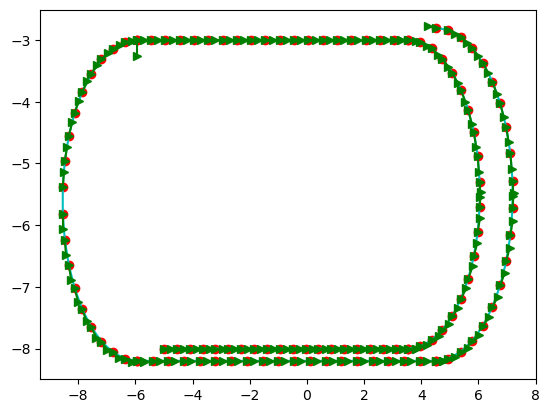

120
120


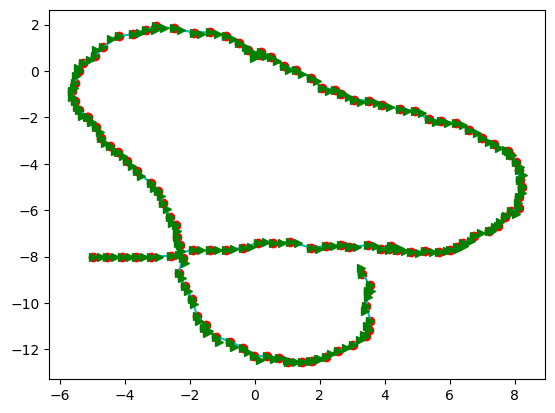

In [8]:
init = []
init = readVertex("../data/edges.txt")
print(init)


x_g,y_g,theta_g = readVertex("../data/gt.txt")
draw(x_g,y_g,theta_g)
saveg2o(x_g,y_g,theta_g,"../results/gt_poses.g2o")
print(np.size(x_g))
x = np.zeros(120)
y = np.zeros(120)
theta = np.zeros(120)
x[0] = init[0]
y[0] = init[1]
theta[0] = init[2]

ind1 = []
ind2 = []
dx = []
dy = []
dtheta = []
ind1, ind2, dx, dy, dtheta = readEdge("../data/edges.txt")

for i in range(119):
    x[i+1] = x[i] + dx[i]*np.cos(theta[i]) - dy[i]*np.sin(theta[i])
    y[i+1] = y[i] + dx[i]*np.sin(theta[i]) + dy[i]*np.cos(theta[i])
    theta[i+1] = theta[i] + dtheta[i]
print(np.size(x))
draw(x,y,theta)
saveg2o(x,y,theta,"../results/edges-poses.g2o")

In [8]:
def resdl(x,y,theta,dx,dy,dtheta):
    # Found fx!!!
    fx = np.zeros(420)
    for i,j in zip(range(0, 354, 3),range(119)):
        fx[i] = x[j] + dx[j]*np.cos(theta[j]) - dy[j]*np.sin(theta[j]) - x[j+1]
        fx[i+1] = y[j] + dx[j]*np.sin(theta[j]) + dy[j]*np.cos(theta[j]) - y[j+1]
        fx[i+2] = dtheta[j] + theta[j] - theta[j+1]

    for i,j,z in zip(range(357, 417, 3),range(0, 40, 2), range(119,139,1)):
        fx[i] = x[j] + dx[z]*np.cos(theta[j]) - dy[z]*np.sin(theta[j]) - x[j+80] 
        fx[i+1] = y[j] + dx[z]*np.cos(theta[j]) + dy[z]*np.sin(theta[j]) - y[j+80]
        fx[i+2] = theta[j] + dtheta[z] - theta[j+80]
    
    fx[417] = x[0] - (-5)
    fx[418] = y[0] - (-8)
    fx[419] = theta[0] - 0
    return fx

In [9]:
def jacobian(theta,dx,dy):
    J = np.zeros((420,360))
    for i in range(119):
        J[3*i][i] = 1
        J[3*i][i+1] = -1
    
        J[3*i + 1][i+120] = 1
        J[3*i + 1][i+1+120] = -1
    
        J[3*i][i+240] = -dx[i]*np.sin(theta[i])-dy[i]*np.cos(theta[i])
        J[3*i+1][i+240] = -dy[i]*np.sin(theta[i])+dx[i]*np.cos(theta[i])
    
        J[3*i+2][i+240] = 1
        J[3*i+2][i+1+240] = -1
    
    for i,j,z in zip(range(357,417,3),range(0,40,2),range(119,139,1)):
        J[i][j] = 1
        J[i][j+80] = -1
    
        J[i+1][j+120] = 1
        J[i+1][j+80+120] = -1
    
        J[i][j+240] = -dx[z]*np.sin(theta[j])-dy[z]*np.cos(theta[j])
        J[i+1][j+240] = -dy[z]*np.sin(theta[j])+dx[z]*np.cos(theta[j])
    
        J[i+2][j+240] = 1
        J[i+2][j+80+240] = -1
    
    J[417][0] = 1
    J[418][120] = 1
    J[419][240] = 1
    
    return J

In [10]:
# omega = np.zeros((420,420))
# for i in range(420):
#     if i < 357:
#         omega[i][i] = 500
#     elif i < 417 and i >= 357:
#         omega[i][i] = 700
#     else:
#         omega[i][i] = 1000

#print(omega[356])

In [37]:
def draw_err(itr,error, num):
    plt.plot(itr, error)
    plt.xlabel('iterations')
    plt.ylabel('logarithm of Error')
    plt.title('Error vs Iterations for ' + ' ' + str(num) + ' iterations')
    plt.grid(True)
    plt.show()

### Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this assignment. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [42]:
def draw_all(X, Y, THETA, itr):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
        
    ax.plot(x_g, y_g, 'ro')
    plt.plot(x_g, y_g, 'c-')

    for i in range(len(theta_g)):
        x2 = 0.25*math.cos(theta_g[i]) + x_g[i]
        y2 = 0.25*math.sin(theta_g[i]) + y_g[i]
        plt.plot([x_g[i], x2], [y_g[i], y2], 'y->')
    
    ax.plot(x, y, 'ro')
    plt.plot(x, y, 'c-')

    for i in range(len(theta)):
        x2 = 0.25*math.cos(theta[i]) + x[i]
        y2 = 0.25*math.sin(theta[i]) + y[i]
        plt.plot([x[i], x2], [y[i], y2], 'r->')
    
    plt.title('2D SLAM for ' + ' ' + str(itr) + ' iterations')
    plt.grid(True)
    plt.show()

In [65]:
def omega_func(odo,lc,anc):
    omega = np.zeros((420,420))
    for i in range(420):
        if i < 357:
            omega[i][i] = odo
        elif i < 417 and i >= 357:
            omega[i][i] = lc
        else:
            omega[i][i] = anc
    return omega

In [73]:
def lm(x,y,theta,dx,dy,dtheta,lamda,omega):
    
    del_error = 0.01
    itr = []
    err_val = []
    fx = resdl(x,y,theta,dx,dy,dtheta)
    prev_err=0.5*np.dot(np.dot(fx.T,omega),fx)

    for i in range(1000):
        lam=lamda
        fx = resdl(x,y,theta,dx,dy,dtheta)
        J = jacobian(theta,dx,dy)
        H=np.dot(np.dot(J.T,omega),J)
        hfx=np.dot(np.dot(J.T,omega.T),fx)
        dx1 = np.linalg.inv(H + lam*np.eye(360))
        dx1 = np.dot(dx1,hfx)

        dxx = dx1[:120]
        dxy = dx1[120:240]
        dxz = dx1[240:]

        final_x = x - dxx
        final_y = y - dxy
        final_theta = theta - dxz
        new_fx = resdl(final_x, final_y, final_theta, dx, dy, dtheta)
    
        new_err=0.5*np.dot(np.dot(new_fx.T,omega),new_fx)
        
        if abs(prev_err-new_err)<del_error:
            print("Converged")
            break
        if new_err<prev_err:
            lam/=10
            x,y,theta = final_x,final_y,final_theta
            print(i, new_err, abs(prev_err-new_err) )
            prev_err=new_err
       
        else:
            lam*=10
            print(i, new_err, abs(prev_err-new_err))
        if i % 180 == 0:  # trajectory plot every 80 iterations
            
            draw_all(final_x, final_y, final_theta, len(itr))
        itr.append(i)
        err_val.append(new_err)
    
    #err_val = np.log(err_val)
    draw_err(itr, err_val, len(itr))
    draw_all(final_x,final_y,final_theta, len(itr))
    

0 69073.96736943917 599185.6339622232


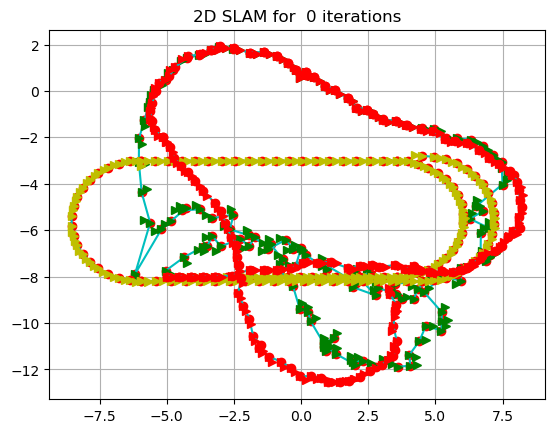

1 2288.2781428801645 66785.689226559
2 1758.033051031105 530.2450918490595
3 1577.966974389127 180.06607664197804
4 1403.1982716078353 174.76870278129172
5 1082.9525649033253 320.24570670451
6 817.9160108350324 265.03655406829296
7 674.8391555977549 143.0768552372774
8 610.7282844378759 64.11087115987903
9 581.2404287152178 29.487855722658082
10 564.0427824905626 17.197646224655273
11 551.0921025085354 12.950679982027168
12 539.7800987681802 11.31200374035518
13 529.3333563920777 10.44674237610252
14 519.5461234350471 9.787232957030596
15 510.3678799875677 9.178243447479417
16 501.7809587139381 8.58692127362957
17 493.7667310630443 8.014227650893815
18 486.2972482793547 7.469482783689614
19 479.3345735501931 6.962674729161563
20 472.83302531819453 6.501548231998584
21 466.7427521758785 6.09027314231605
22 461.0136479380887 5.729104237789784
23 455.59876402368053 5.414883914408165
24 450.45665248181587 5.142111541864665
25 445.55246327891206 4.904189202903808
26 440.85796011646283 4.694

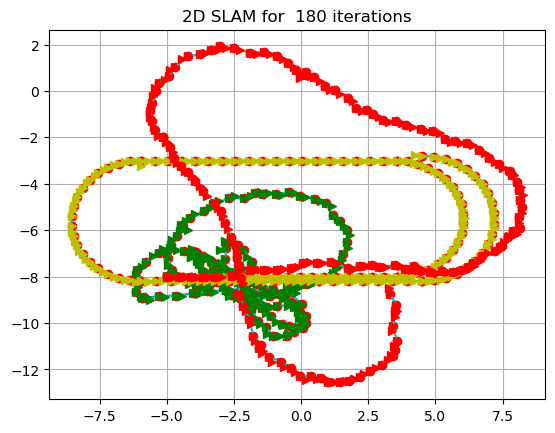

181 218.539613729952 0.6249282077144755
182 217.91607326888396 0.6235404610680462
183 217.2937670445902 0.6223062242937658
184 216.6725349281029 0.621232116487306
185 216.0522100827548 0.6203248453480796
186 215.43261894781622 0.6195911349385881
187 214.8135813046709 0.619037643145333
188 214.19491043574084 0.6186708689300531
189 213.57641338596486 0.6184970497759821
190 212.95789133592814 0.6185220500367166
191 212.3391400946619 0.6187512412662386
192 211.71995071869108 0.6191893759708194
193 211.1001102620862 0.6198404566048907
194 210.47940266008897 0.6207076019972249
195 209.85760974636378 0.6217929137251872
196 209.23451240112487 0.6230973452389037
197 208.60989182436566 0.624620576759213
198 207.98353092527734 0.6263608990883256
199 207.35521581576887 0.6283151095084634
200 206.72473739292323 0.6304784228456413
201 206.09189299235427 0.6328444005689562
202 205.45648809188827 0.6354049004659998
203 204.81833804290153 0.6381500489867449
204 204.1772698050834 0.641068237818132
205 2

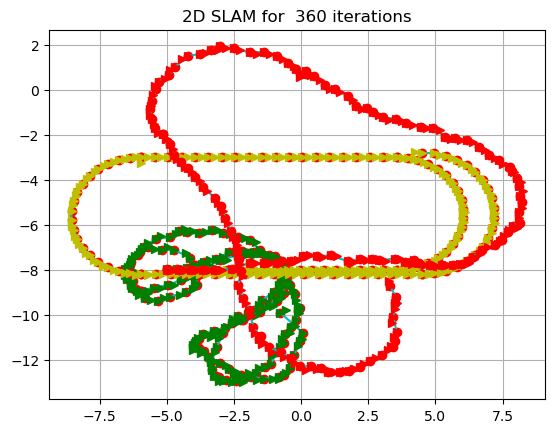

361 129.45092398814685 0.2649940661813446
362 129.18686493139126 0.26405905675559893
363 128.9237319728004 0.26313295859085883
364 128.6615167370389 0.262215235761488
365 128.4002113704038 0.2613053666350993
366 128.13980852662053 0.2604028437832824
367 127.88030135271839 0.2595071739021364
368 127.62168347498293 0.2586178777354604
369 127.36394898497407 0.2577344900088576
370 127.10709242560807 0.2568565593659997
371 126.85110877729944 0.25598364830862863
372 126.59599344415481 0.2551153331446301
373 126.34174224022206 0.25425120393275336
374 126.08835137578784 0.2533908644342233
375 125.83581744372573 0.25253393206210717
376 125.58413740589562 0.2516800378301127
377 125.33330857959385 0.2508288263017704
378 125.08332862405992 0.24997995553393082
379 124.83419552703994 0.24913309701997832
380 124.58590759141592 0.2482879356240204
381 124.33846342190387 0.2474441695120504
382 124.09186191182935 0.24660151007451248
383 123.84610222998799 0.24575968184136343
384 123.60118380760132 0.2449

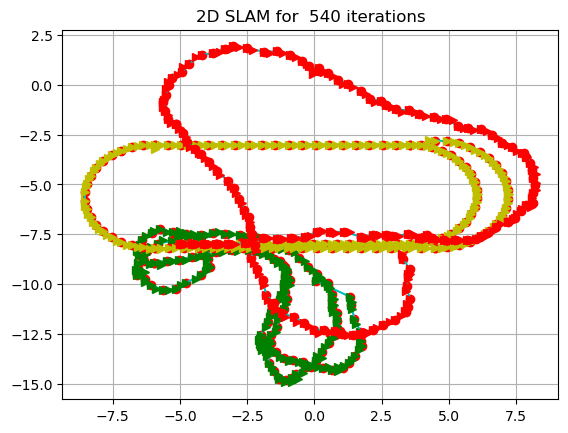

541 96.23859481947069 0.10498911065907635
542 96.13442412244554 0.10417069702515391
543 96.03106940863476 0.10335471381077355
544 95.92852821333909 0.10254119529567163
545 95.8267980373223 0.1017301760167868
546 95.72587634656668 0.10092169075562651
547 95.62576057204197 0.10011577452470988
548 95.52644810948661 0.09931246255536053
549 95.42793631920247 0.09851179028413526
550 95.33022252586534 0.09771379333713526
551 95.2333040183478 0.09691850751754316
552 95.13717804955988 0.09612596878791635
553 95.04184183630332 0.09533621325655872
554 94.94729255914227 0.09454927716105033
555 94.85352736229117 0.09376519685109486
556 94.7605433535198 0.09298400877138135
557 94.66833760407428 0.09220574944551174
558 94.57690714861721 0.09143045545707196
559 94.48624898518572 0.0906581634314847
560 94.39636007516766 0.0898889100180611
561 94.30723734329753 0.08912273187013398
562 94.21887767767033 0.08835966562719477
563 94.13127792977713 0.08759974789320779
564 94.04443491455886 0.0868430152182639

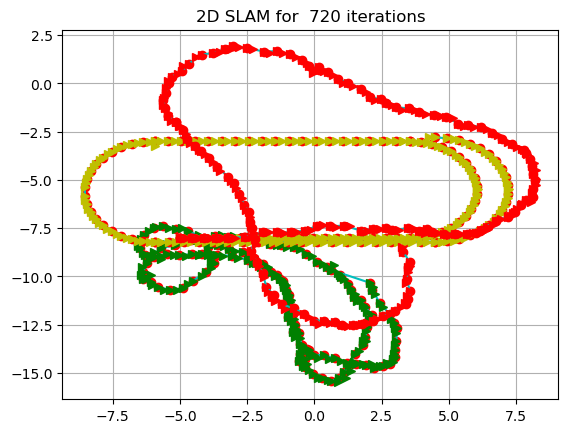

721 87.15952284547707 0.017731773899583914
722 87.14195261131539 0.017570234161681242
723 87.12454169318106 0.017410918134331155
724 87.10728789449931 0.017253798681750254
725 87.0901890456521 0.01709884884721191
726 87.07324300379533 0.01694604185676951
727 87.05644765267344 0.01679535112188546
728 87.03980090243199 0.016646750241449126
729 87.02330068942723 0.016500213004761122
730 87.00694497603384 0.01635571339339492
731 86.99073175045021 0.016213225583626922
732 86.97465902650143 0.01607272394878123
733 86.95872484344135 0.01593418306008232
734 86.9429272657517 0.015797577689639297
735 86.92726438294025 0.015662882811454892
736 86.91173430933709 0.015530073603159167
737 86.89633518388973 0.015399125447359552
738 86.88106516995647 0.015270013933260884
739 86.86592245509893 0.01514271485754648
740 86.85090525087332 0.015017204225600267
741 86.83601179262045 0.014893458252871028
742 86.82124033925498 0.014771453365469256
743 86.80658917305423 0.014651166200749799
744 86.7920565994453

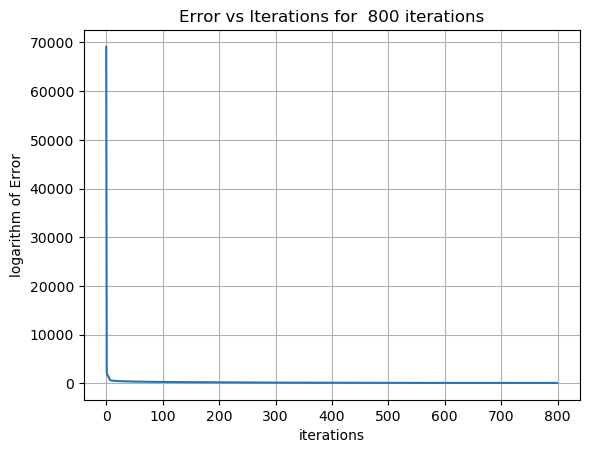

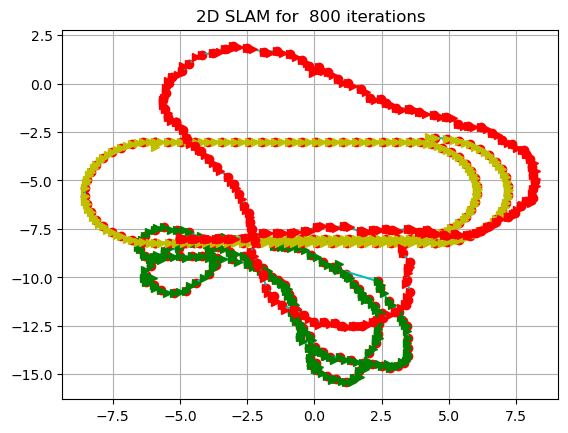

In [74]:
omega = omega_func(50,700,1000)
lm(x,y,theta,dx,dy,dtheta,10,omega)

0 20645.6093063578 27087.219360189512


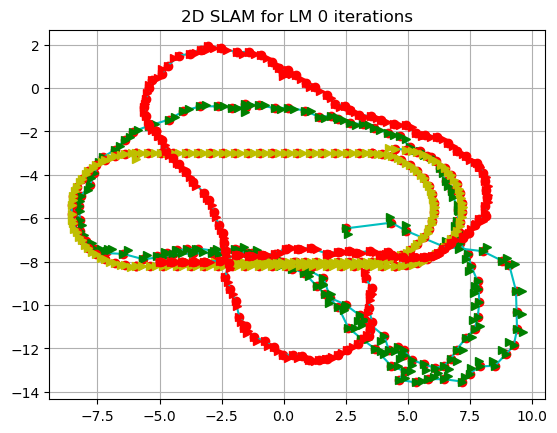

1 9601.302596079375 11044.306710278426
2 7279.842815816297 2321.459780263078
3 5435.20427668544 1844.6385391308568
4 3946.8842551899625 1488.3200214954777
5 2610.1012534514907 1336.7830017384717
6 2004.6437637082126 605.4574897432781
7 1796.0698352902205 208.5739284179922
8 1674.0993606621935 121.97047462802698
9 1592.1235840435238 81.97577661866967
10 1530.8884043718892 61.23517967163457
11 1480.5666168529315 50.32178751895776
12 1436.0527783708212 44.51383848211026
13 1394.8808429667235 41.17193540409767
14 1356.1508117232386 38.73003124348497
15 1319.7469963439746 36.40381537926396
16 1285.6095304337346 34.13746591024005
17 1253.293314383977 32.316216049757486
18 1222.0110794850254 31.28223489895163
19 1190.9638325823396 31.047246902685856
20 1159.6454167596055 31.318415822734096
21 1127.9933567955688 31.652059964036653
22 1096.3800040877186 31.613352707850254
23 1065.456944284621 30.923059803097658
24 1035.906927014932 29.55001726968885
25 1008.2209755021216 27.685951512810448
26 9

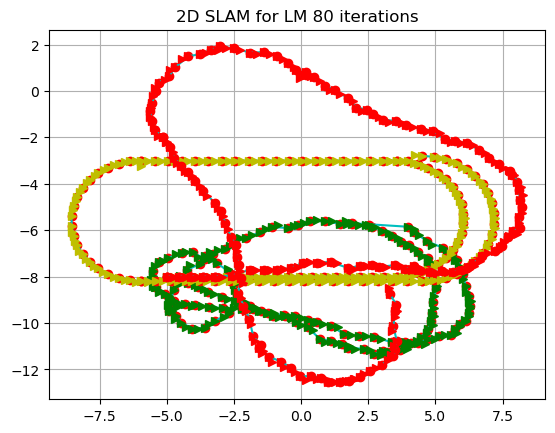

81 683.9347290303267 0.309511892789601
82 683.6408084267385 0.2939206035881625
83 683.3612111912635 0.2795972354750802
84 683.094791539458 0.2664196518054496
85 682.8405131753472 0.2542783641108599
86 682.5974379977193 0.24307517762781572
87 682.3647160158428 0.23272198187657978
88 682.1415763443233 0.2231396715194478
89 681.9273191603046 0.21425718401872018
90 681.7213085185027 0.20601064180186768
91 681.522965930679 0.19834258782373126
92 681.3317646262055 0.19120130447345218
93 681.147224419409 0.18454020679655514
94 680.9689071174913 0.17831730191767292
95 680.7964124100839 0.17249470740739525
96 680.6293741879944 0.16703822208955899
97 680.4674572444904 0.16191694350391117
98 680.3103543176334 0.15710292685707827
99 680.1577834367802 0.15257088085320447
100 680.0094855404512 0.14829789632892698
101 679.8652223364079 0.14426320404334092
102 679.7247743780124 0.14044795839549806
103 679.5879393338143 0.13683504419805104
104 679.4545304298439 0.13340890397046223
105 679.324375046378 

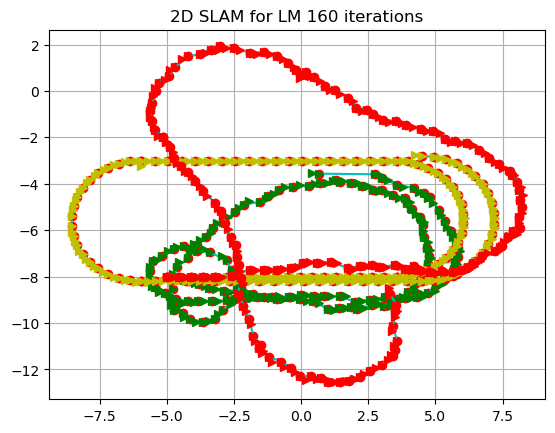

161 674.7957691159431 0.05275254240098093
162 674.7436727902397 0.05209632570347367
163 674.6922218483787 0.05145094186093502
164 674.6414057350986 0.05081611328012059
165 674.5912141615416 0.05019157355695825
166 674.5416370946834 0.0495770668582054
167 674.4926647473435 0.048972347339940825
168 674.4442875687328 0.04837717861073543
169 674.3964962355087 0.0477913332240405
170 674.3492816432966 0.04721459221207169
171 674.3026348986574 0.04664674463924712
172 674.2565473114674 0.04608758718995887
173 674.2110103876822 0.045536923785221006
174 674.1660158224647 0.04499456521750744
175 674.1215554936512 0.04446032881355677
176 674.0776214555442 0.043934038106954176
177 674.03420593299 0.043415522554255404
178 673.9913013157542 0.042904617235763
179 673.9489001531529 0.04240116260132254
180 673.9069951489306 0.04190500422225796
181 673.8655791563805 0.04141599255012807
182 673.8246451736791 0.04093398270140369
183 673.7841863394342 0.04045883424487329
184 673.7441959284231 0.039990411011

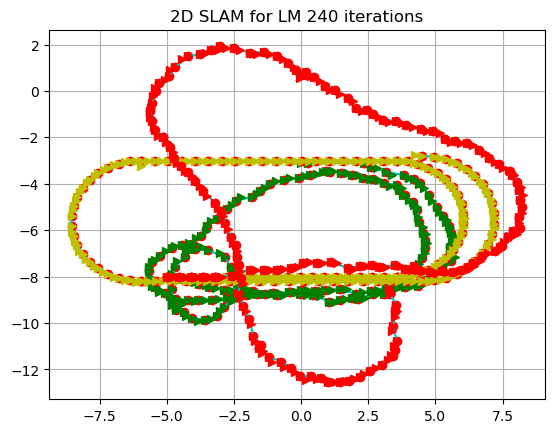

241 672.0693750824381 0.021331924054265983
242 672.0482676342623 0.021107448175825994
243 672.0273820649613 0.020885569300958196
244 672.0067158128968 0.020666252064529544
245 671.9862663511842 0.020449461712587436
246 671.966031187096 0.020235164088262536
247 671.9460078614798 0.020023325616193688
248 671.9261939481864 0.019813913293319274
249 671.9065870535162 0.019606894670232577
250 671.8871848156713 0.019402237844929004
251 671.8679849042238 0.019199911447458362
252 671.848985019596 0.018999884627874053
253 671.830182892548 0.018802127047933936
254 671.8115762836816 0.018606608866434726
255 671.7931629829513 0.01841330073023073
256 671.7749408091846 0.01822217376673052
257 671.7569076096179 0.018033199566730218
258 671.7390612594367 0.017846350181230264
259 671.7213996613274 0.017661598109270926
260 671.703920745038 0.017478916289405788
261 671.6866224669516 0.017298278086400387
262 671.6695028096585 0.017119657293051205
263 671.6525597815522 0.01694302810631143
264 671.6357914164

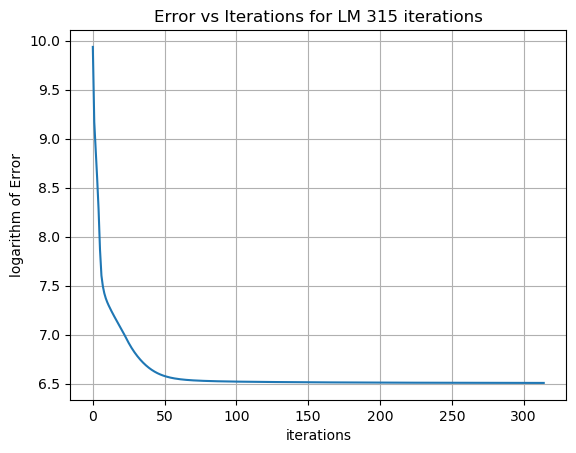

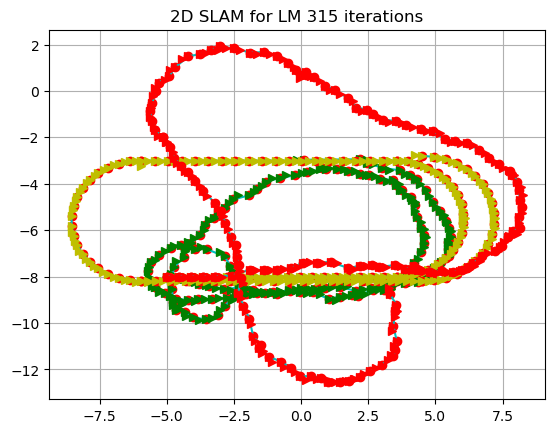

In [29]:
omega= omega_func(700,50,1000)
lm(x,y,theta,dx,dy,dtheta,1,omega)

### Experiments:

| Sr. | Odometry | Loop closure | Anchor points | Lamda | Convergence itr. | Result |
|---|---|---|---|---|---|---|
| 1 | 700 | 500 | 1000 | 1 | 170 | ![title](../results/iter0.png) |
| 2 | 700 | 50 | 1000 | 1 | 315 | ![title](../results/iter1.png) |
| 6 | 500 | 700 | 700 | 1 | 59 | ![title](../results/iter2.png) |
| 2 | 700 | 500 | 1000 | 10 | 377 | ![title](../results/iter3.png) |
| 3 | 500 | 100 | 100 | 10 | 2521 | ![title](../results/iter4.png) |
| 4 | 700 | 200 | 1000 | 10 | 572 | ![title](../results/iter5.png) |
| 5 | 100 | 700 | 1000 | 100 | 3616 | ![title](../results/iter6.png) |
| 7 | 700 | 500 | 100 | 100 | 5000 |  |
| 8 | 200 | 200 | 600 | 100 | 3160 | ![title](../results/iter8.png) |

# keeping odom lc values less gets the error below 40.

### Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

fx is an array with 420 elements, where each element corresponds to a different residual term.
The structure of fx is as follows:
The first 357 elements correspond to the differences in x, y, and theta between adjacent poses (vertex-vertex constraints) and are computed based on the robot motion and odometry information.
The next 60 elements correspond to loop closure constraints, comparing the poses corresponding to landmarks (loop constraints).
The final 3 elements represent anchor constraints, fixing the absolute position of the initial pose.

J is a dense matrix with a shape of (420, 360).
The structure of J can be explained as follows:

Each row of J corresponds to a different residual equation.
The first 357 rows of J correspond to vertex-vertex constraints, where each constraint affects two poses (a total of 119 constraints).
The next 60 rows of J correspond to loop closure constraints, where each constraint affects two poses (a total of 20 constraints).
The final 3 rows of J correspond to anchor constraints, fixing the initial position.
The columns of J represent partial derivatives with respect to 360 variables (120 x-positions, 120 y-positions, and 120 thetas).

### Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [9]:
#done above